## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

did not find corners in calibration1.jpg
did not find corners in calibration4.jpg
did not find corners in calibration5.jpg


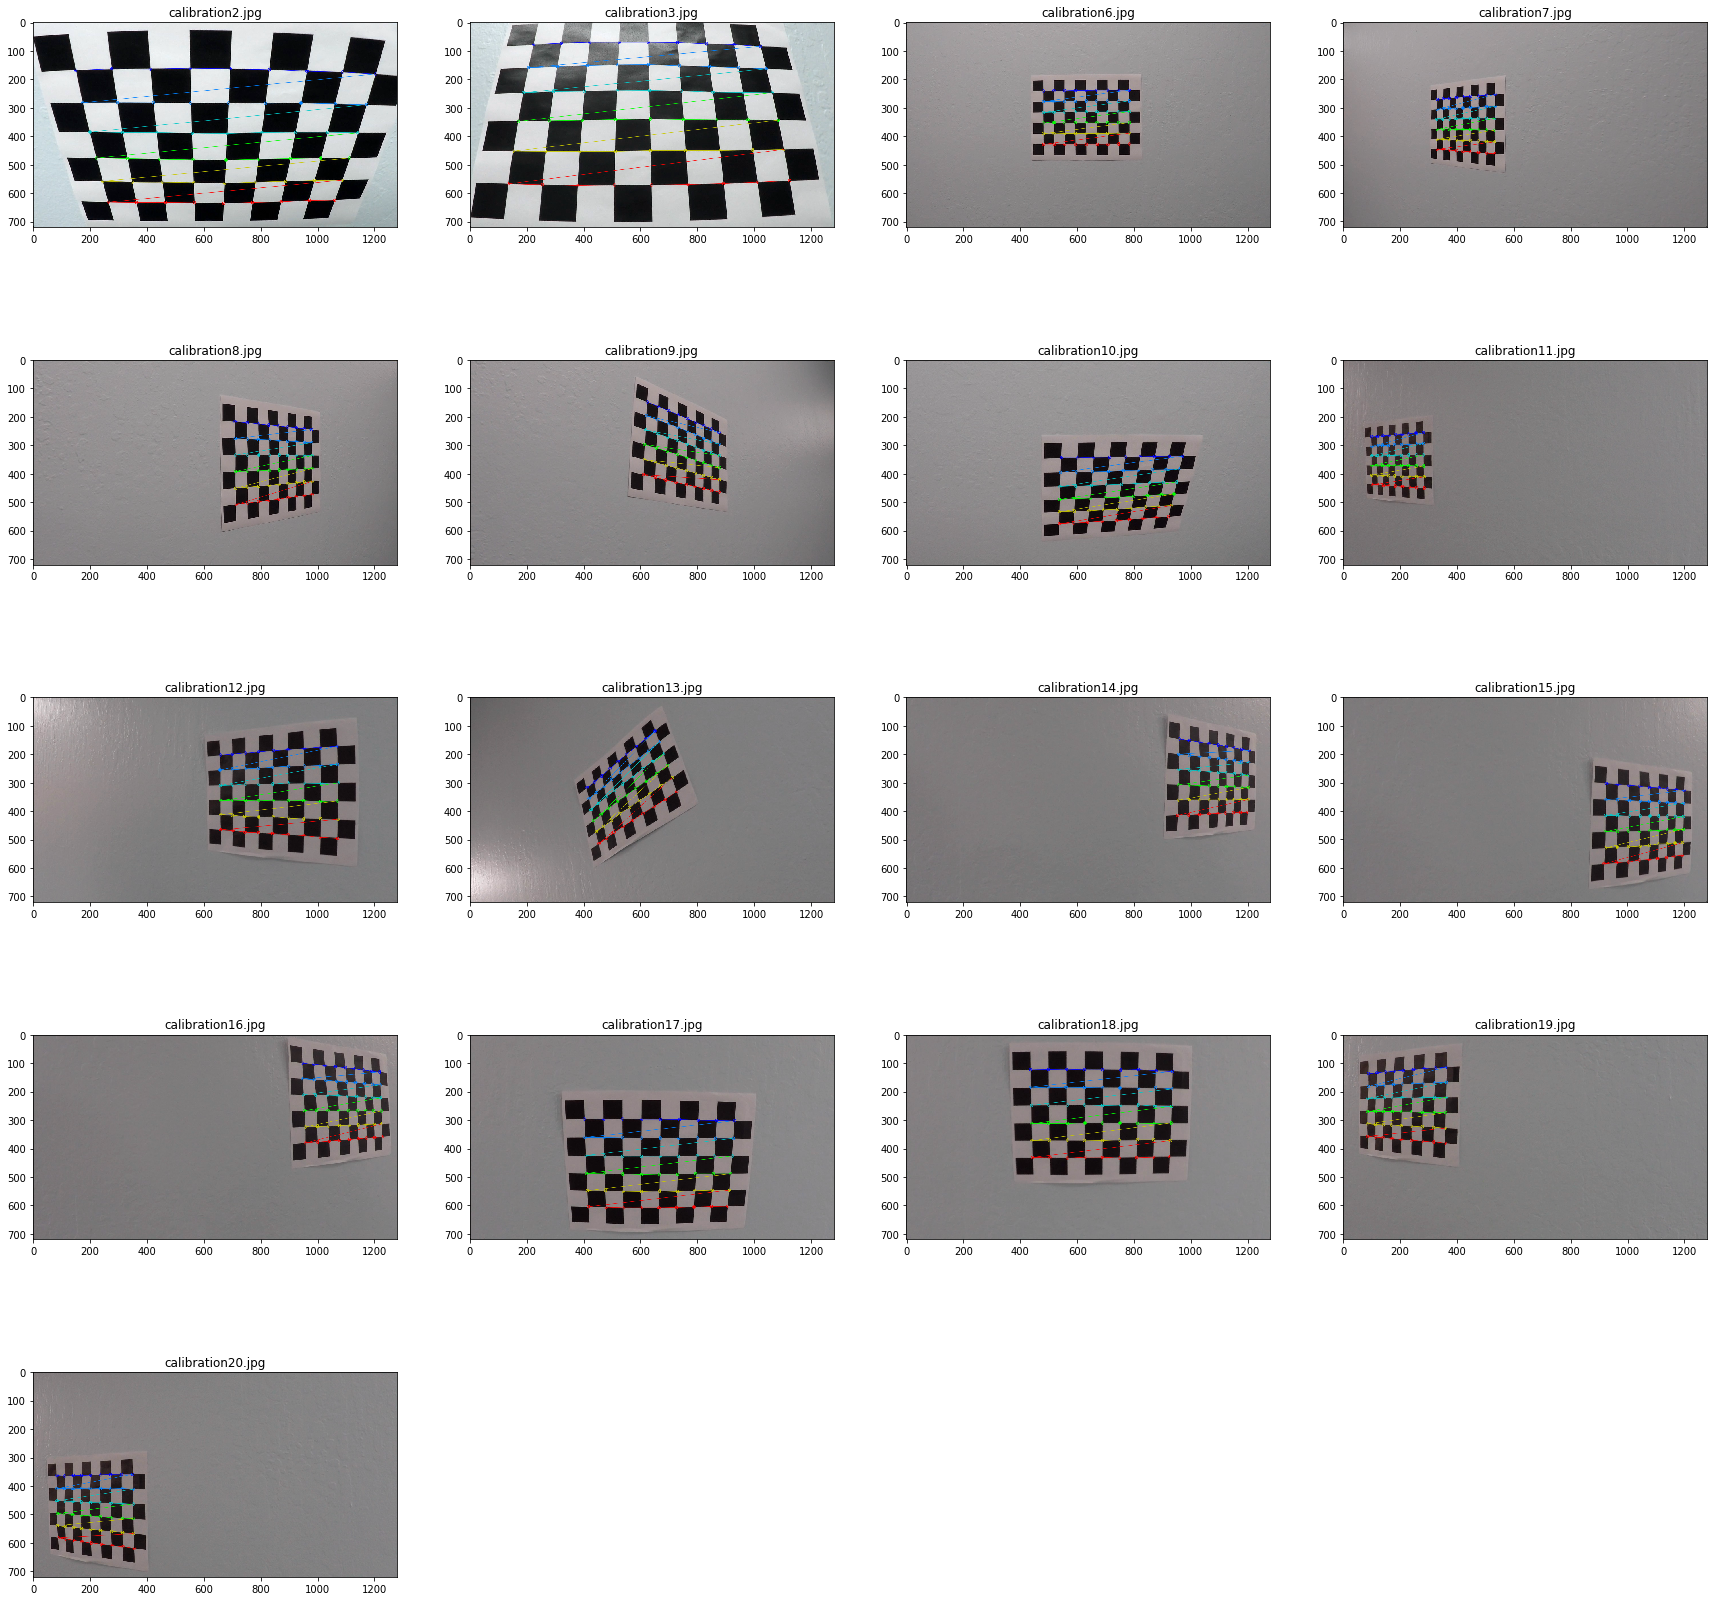

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
#%matplotlib qt
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = []
for idx in range(20):
    images.append('./camera_cal/calibration{}.jpg'.format(idx+1))
# images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
i = 1
plt.figure(1,figsize=(30,30))
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        plt.subplot(5, 4, i)
        plt.title(fname.split('/')[-1])
        i= i+1
        plt.imshow(img)
    else:
        print('did not find corners in {}'.format(fname.split('/')[-1]))


### Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

In [2]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

### Apply a distortion correction to raw images.

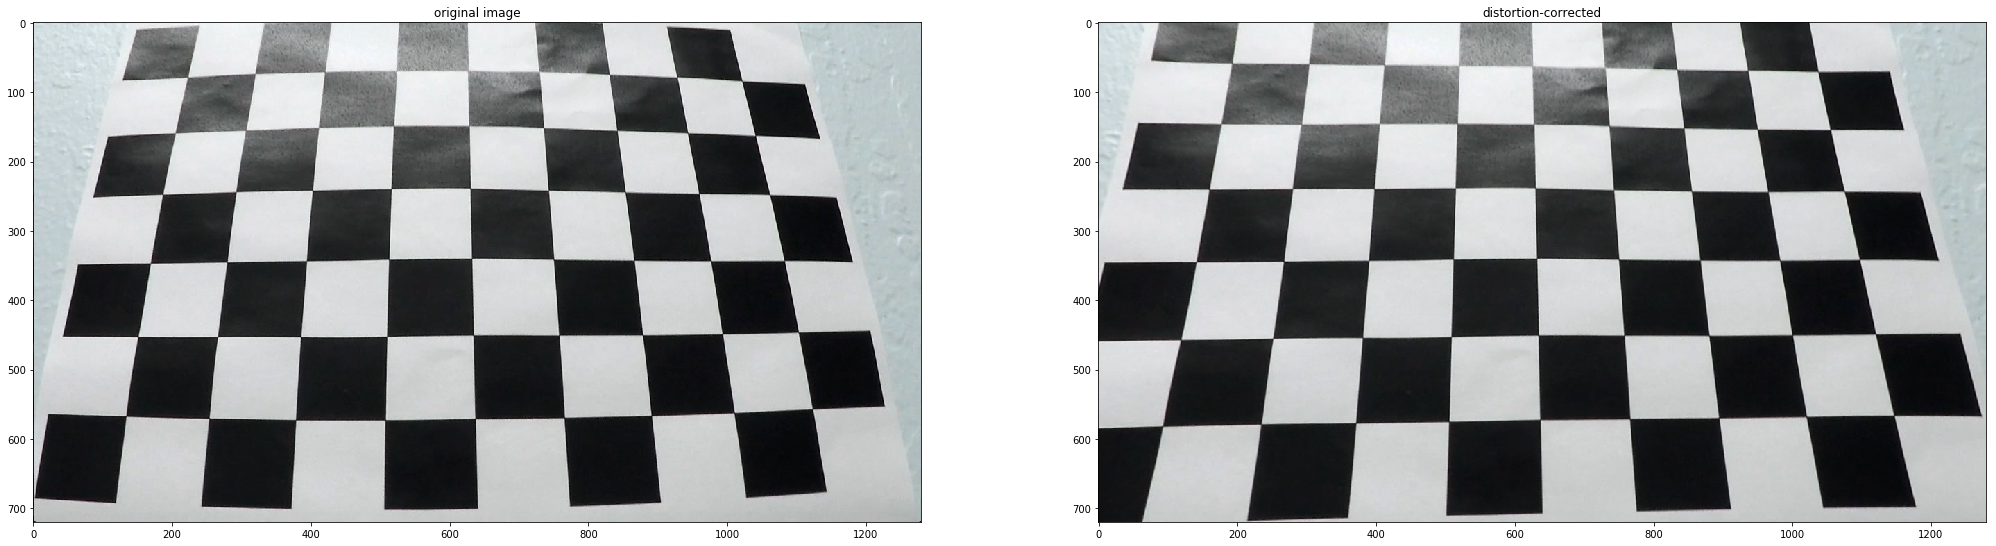

In [3]:
image_to_show = 2
example_image = cv2.imread(images[image_to_show])
# example_image = plt.imread("test_images/straight_lines2.jpg")
plt.figure(1,figsize=(35,60))
plt.subplot(121)
plt.title('original image')
plt.imshow(example_image)
undist = cv2.undistort(example_image, mtx, dist, None, mtx)
plt.imsave("test_images/undist.jpg",undist)
plt.subplot(122)
plt.title('distortion-corrected')
plt.imshow(undist)

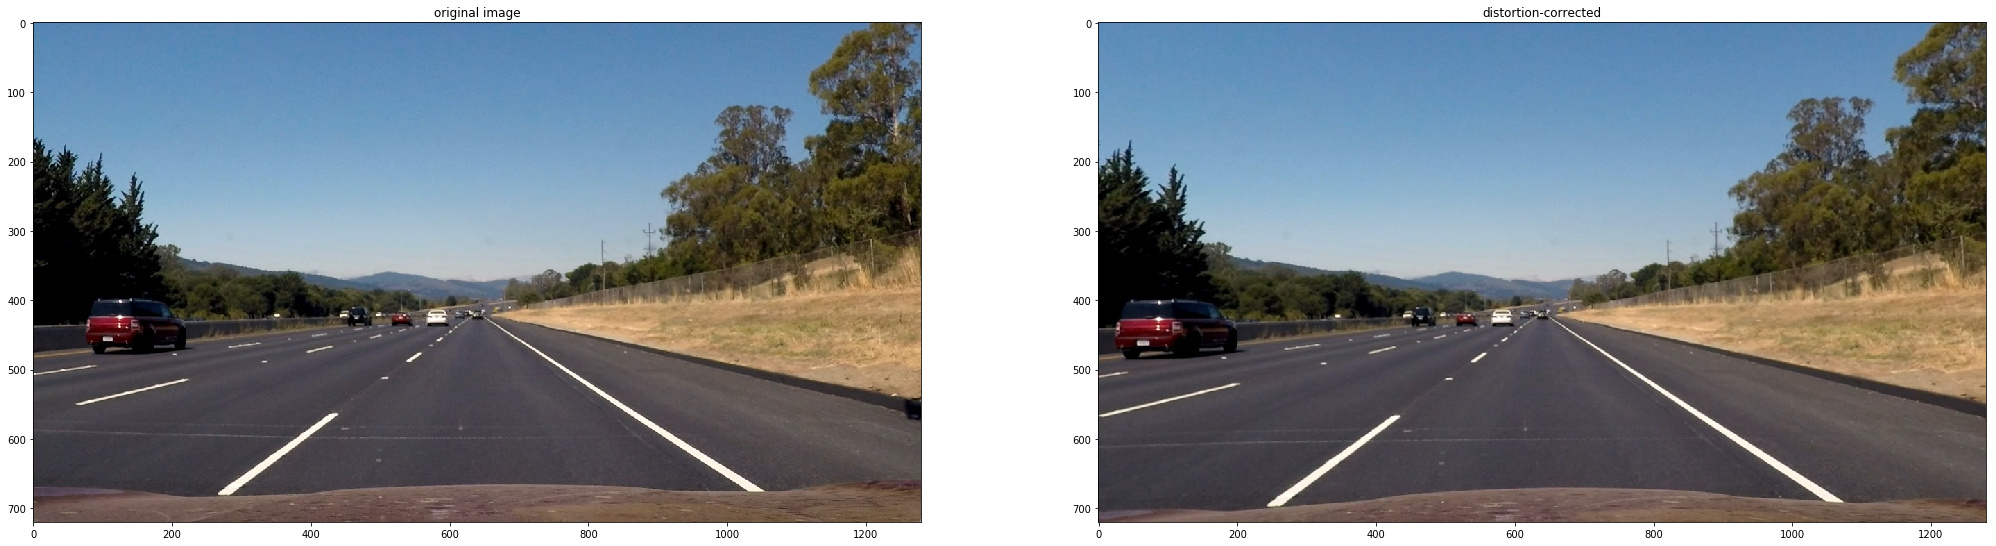

In [4]:
example_image = plt.imread("test_images/straight_lines2.jpg")
plt.figure(1,figsize=(35,60))
plt.subplot(121)
plt.title('original image')
plt.imshow(example_image)
undist = cv2.undistort(example_image, mtx, dist, None, mtx)
# plt.imsave("test_images/undist.jpg",undist)
plt.subplot(122)
plt.title('distortion-corrected')
plt.imshow(undist)

### Use color transforms, gradients, etc., to create a thresholded binary image

### helper functions
#### fill contours, region_of_interest

In [5]:
 def fill_contours(gray):
    tmp = gray.copy()
    tmp = cv2.morphologyEx(tmp,cv2.MORPH_GRADIENT,cv2.getStructuringElement(cv2.MORPH_ELLIPSE,ksize=(3,3)))
    tmp = cv2.bitwise_not(tmp)
    smallholes = np.zeros_like(tmp)
    _, contours, _ = cv2.findContours(tmp, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    for i in range(len(contours)):
        area = cv2.contourArea(contours[i])
        if area < 500:
            cv2.drawCountours(smallholes, contours, i, 1, -1)
    done = cv2.bitwise_or(gray,smallholes)
    done = cv2.morphologyEx(done, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, ksize=(10,10)))
    return done

def region_of_interest(img, vertices=[]):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    imshape = np.shape(img)
    if not vertices:
        y_level = np.int(imshape[0]*0.6)
        vertices = np.array([[(np.int(imshape[1]*0.08), imshape[0]-20),
                              (np.int(imshape[1]*.92), imshape[0]-20),
                              (np.int(imshape[1]*.55), y_level),
                              (np.int(imshape[1]*.45), y_level)]],
                        dtype=np.int32)
    
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

#### Sobel Thresh

In [6]:
def abs_sobel_thresh(gray, orient='x', sobel_kernel=3, thresh=(0, 255), fill=False):
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    elif orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    else:
        print("only 'x' or 'y' can be orient argument.")
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    if fill:
        grad_binary = fill_contours(grad_binary)
    return grad_binary

def mag_thresh(gray, sobel_kernel=3, mag_thresh=(0, 255), fill=False):
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Calculate the magnitude 
    abs_sobel = np.sqrt(np.square(sobelx) + np.square(sobely))
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a binary mask where mag thresholds are met
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    if fill:
        mag_binary = fill_contours(mag_binary)
    return mag_binary

def dir_threshold(gray, sobel_kernel=3, thresh=(0, np.pi/2)):
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    absgraddir = np.arctan2(abs_sobely, abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    dir_binary =  np.zeros_like(absgraddir)
    dir_binary[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return dir_binary

def sobel_thresh(img, debug=0):
#     gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)[:,:,2]
    ksize = 5 
    gradx = abs_sobel_thresh(gray, orient='x', sobel_kernel=ksize, thresh=(20, 100), fill=False)
    grady = abs_sobel_thresh(gray, orient='y', sobel_kernel=ksize, thresh=(20, 100), fill=False)
    mag_binary = mag_thresh(gray, sobel_kernel=ksize, mag_thresh=(20, 100), fill=False)
    dir_binary = dir_threshold(gray, sobel_kernel=ksize, thresh=(0.6, 1.3))
    if debug:
        f, (ax1, ax2) = plt.subplots(2, 2, figsize=(24, 18))
        f.tight_layout()
        ax1[0].imshow(gradx, cmap='gray')
        ax1[0].set_title('gradx', fontsize=50)
        ax1[1].imshow(grady, cmap='gray')
        ax1[1].set_title('grady', fontsize=50)
        ax2[0].imshow(mag_binary, cmap='gray')
        ax2[0].set_title('mag_binary', fontsize=50)
        ax2[1].imshow(dir_binary, cmap='gray')
        ax2[1].set_title('dir_binary', fontsize=50)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

    combined = np.zeros_like(dir_binary)
    combined[(gradx == 1) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    return combined

#### Color Thresh

In [7]:
def hls_s(img, thresh=(0, 255), fill=False):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    S = hls[:,:,2]
#     plt.imshow(S, cmap='gray')
    # 2) Apply a threshold to the S channel
    color_thresh = np.zeros_like(S)
    color_thresh[(S > thresh[0]) & (S <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    if fill:
        color_thresh = fill_contours(color_thresh)
    return color_thresh

def hls_h(img, thresh=(20, 40), fill=False):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    H = hls[:,:,0]
    # 2) Apply a threshold to the S channel
    color_thresh = np.zeros_like(H)
    color_thresh[(H > thresh[0]) & (H <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    if fill:
        color_thresh = fill_contours(color_thresh)
    return color_thresh

def hls_l(img, thresh=(0, 20), fill=False):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    L = hls[:,:,1]
    # 2) Apply a threshold to the S channel
    color_thresh = np.zeros_like(L)
    color_thresh[(L > thresh[0]) & (L <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    if fill:
        color_thresh = fill_contours(color_thresh)
    return color_thresh

def hsv_s(img, thresh=(0, 10), fill=False):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    S = hsv[:,:,1]
    color_thresh = np.zeros_like(S)
    color_thresh[(S > thresh[0]) & (S <= thresh[1])] = 1
    if fill:
        color_thresh = fill_contours(color_thresh)
    return color_thresh

def hsv_h(img, thresh=(0, 10), fill=False):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    H = hsv[:,:,0]
    color_thresh = np.zeros_like(H)
    color_thresh[(H > thresh[0]) & (H <= thresh[1])] = 1
    if fill:
        color_thresh = fill_contours(color_thresh)
    return color_thresh

def color_thresh(img, debug=0, fill=False):
    s_hls = hls_s(img, thresh=(95, 255), fill=False)
    h_hls = hls_h(img, thresh=(15, 50), fill=False)
    s_hsv = hsv_s(img, thresh=(100, 255), fill=False)
    l_hls = hls_l(img, thresh=(220, 255), fill=False) # (220,255) works fine
    h_hsv = hsv_h(img, thresh=(15,60), fill=False)
    combined = np.zeros_like(s_hls)
    combined[(s_hls == 1) & (h_hls == 1)] = 1
    if fill:
        combined = fill_contours(combined)
    combined[(combined==1)|(l_hls==1)]=1
#     combined[(s_hls == 1) & (h_hls == 1) | (l_hls == 1)] = 1
    if debug:
        f, ax = plt.subplots(2, 2, figsize=(24, 18))
        f.tight_layout()
        ax[0,0].imshow(s_hls, cmap='gray')
        ax[0,0].set_title('hls_s', fontsize=50)
        ax[0,1].imshow(s_hsv, cmap='gray')
        ax[0,1].set_title('hsv_s', fontsize=50)
        ax[1,0].imshow(h_hls, cmap='gray')
        ax[1,0].set_title('hls_h', fontsize=50)
        ax[1,1].imshow(l_hls, cmap='gray')
        ax[1,1].set_title('hls_l', fontsize=50)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    return combined

### Combine Color and Gradient threshold together

In [8]:
def combine_color_grad(img, debug=False):
    sobel_binary = sobel_thresh(img, debug=debug)
    color_binary = color_thresh(img, debug=debug)
    combined = np.zeros_like(sobel_binary)
    combined[(color_binary == 1)] = 1
    return combined

#### Apply a perspective transform to rectify binary image ("birds-eye view").

In [9]:
def find_matrix():
    src = np.float32([[586, 455],[699, 455],[250,691],[1076,691]])
    des = np.float32([[449.5, 200],[852.5, 200],[449.5,720],[852.5,720]])
    M = cv2.getPerspectiveTransform(src, des)
    Minv = cv2.getPerspectiveTransform(des, src)
    return M, Minv

def birds_eye(undist, M, debug=False):
    img_size = (undist.shape[1], gray.shape[0])
    warped = cv2.warpPerspective(undist, M, (1280,720))
#     warped[warped.nonzero()] = 1
#     warped = np.uint8(warped)
    if debug:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
        f.tight_layout()
        ax1.imshow(undist, cmap='gray')
#         ax1.imshow(undist)
        ax1.set_title('image send to bird_eye', fontsize=50)
        ax2.imshow(warped, cmap='gray')
#         ax2.imshow(warped)
        ax2.set_title('birds eye view', fontsize=50)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
    return warped

## Readin Image and Test

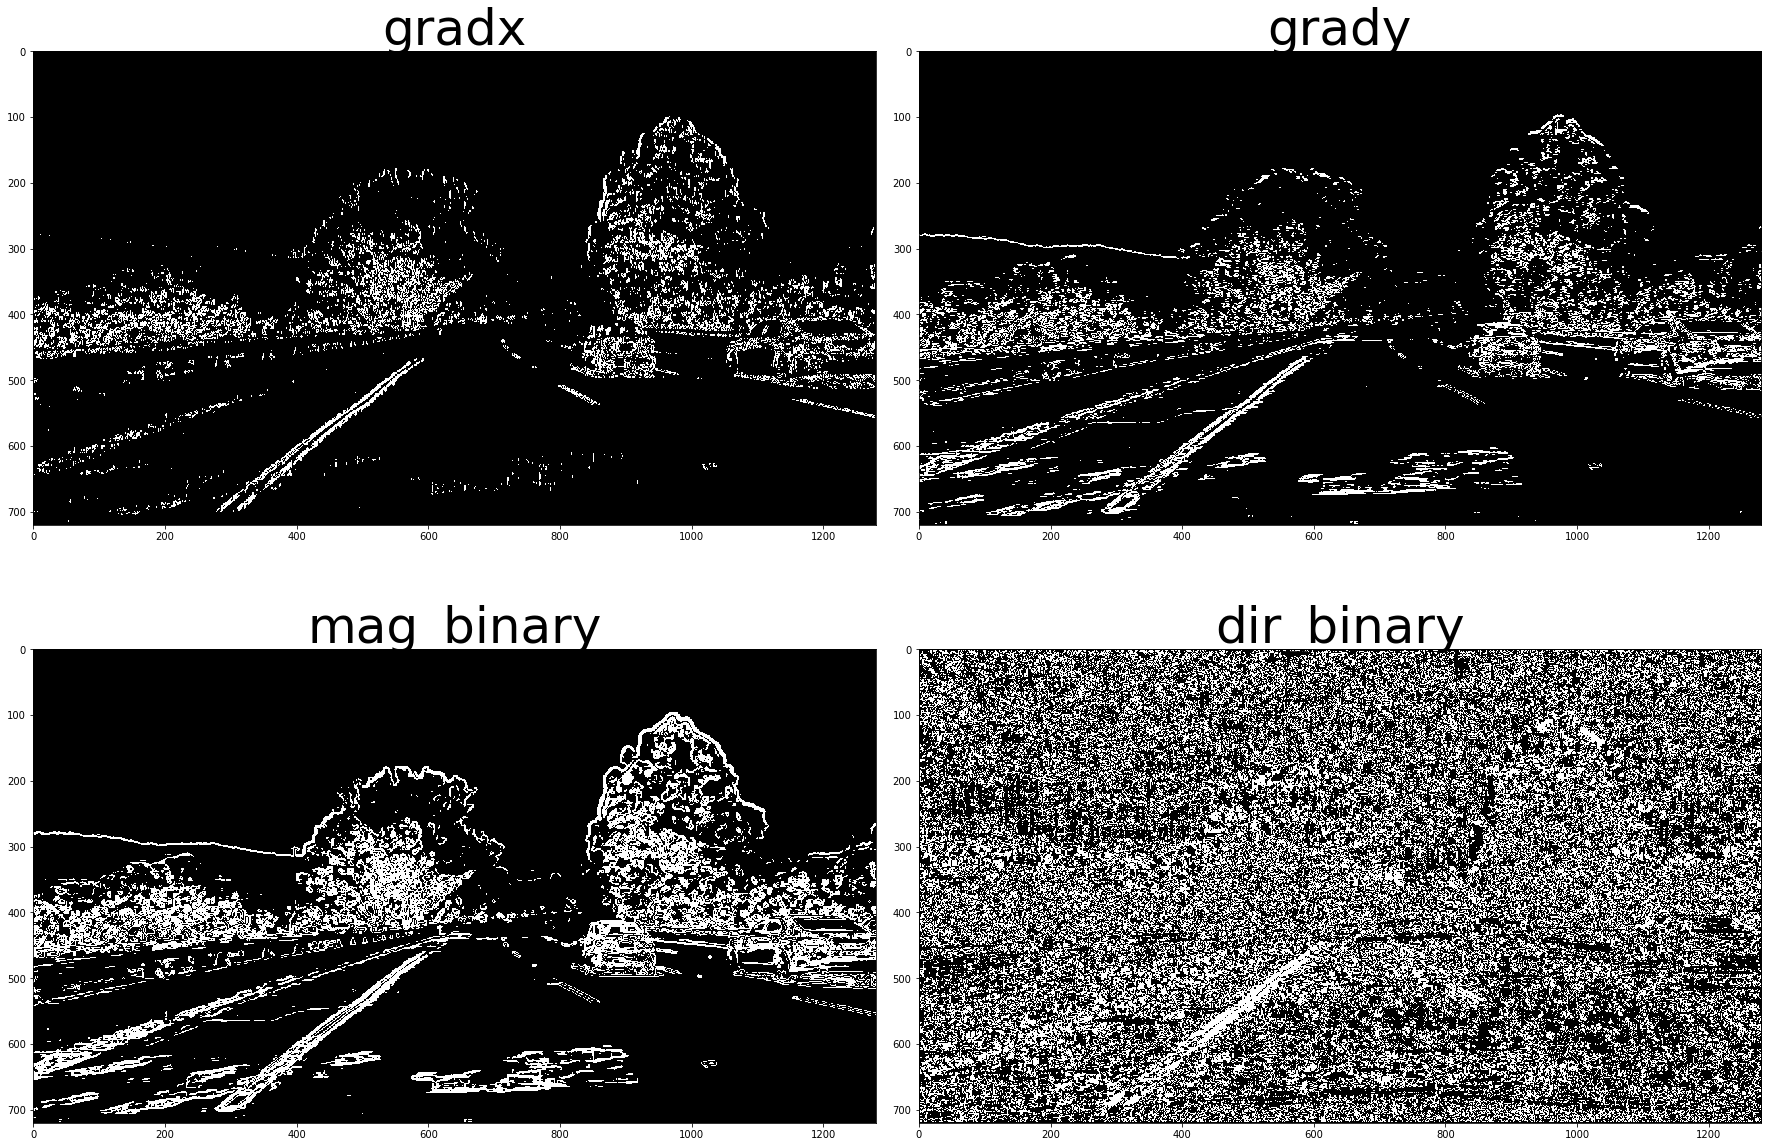

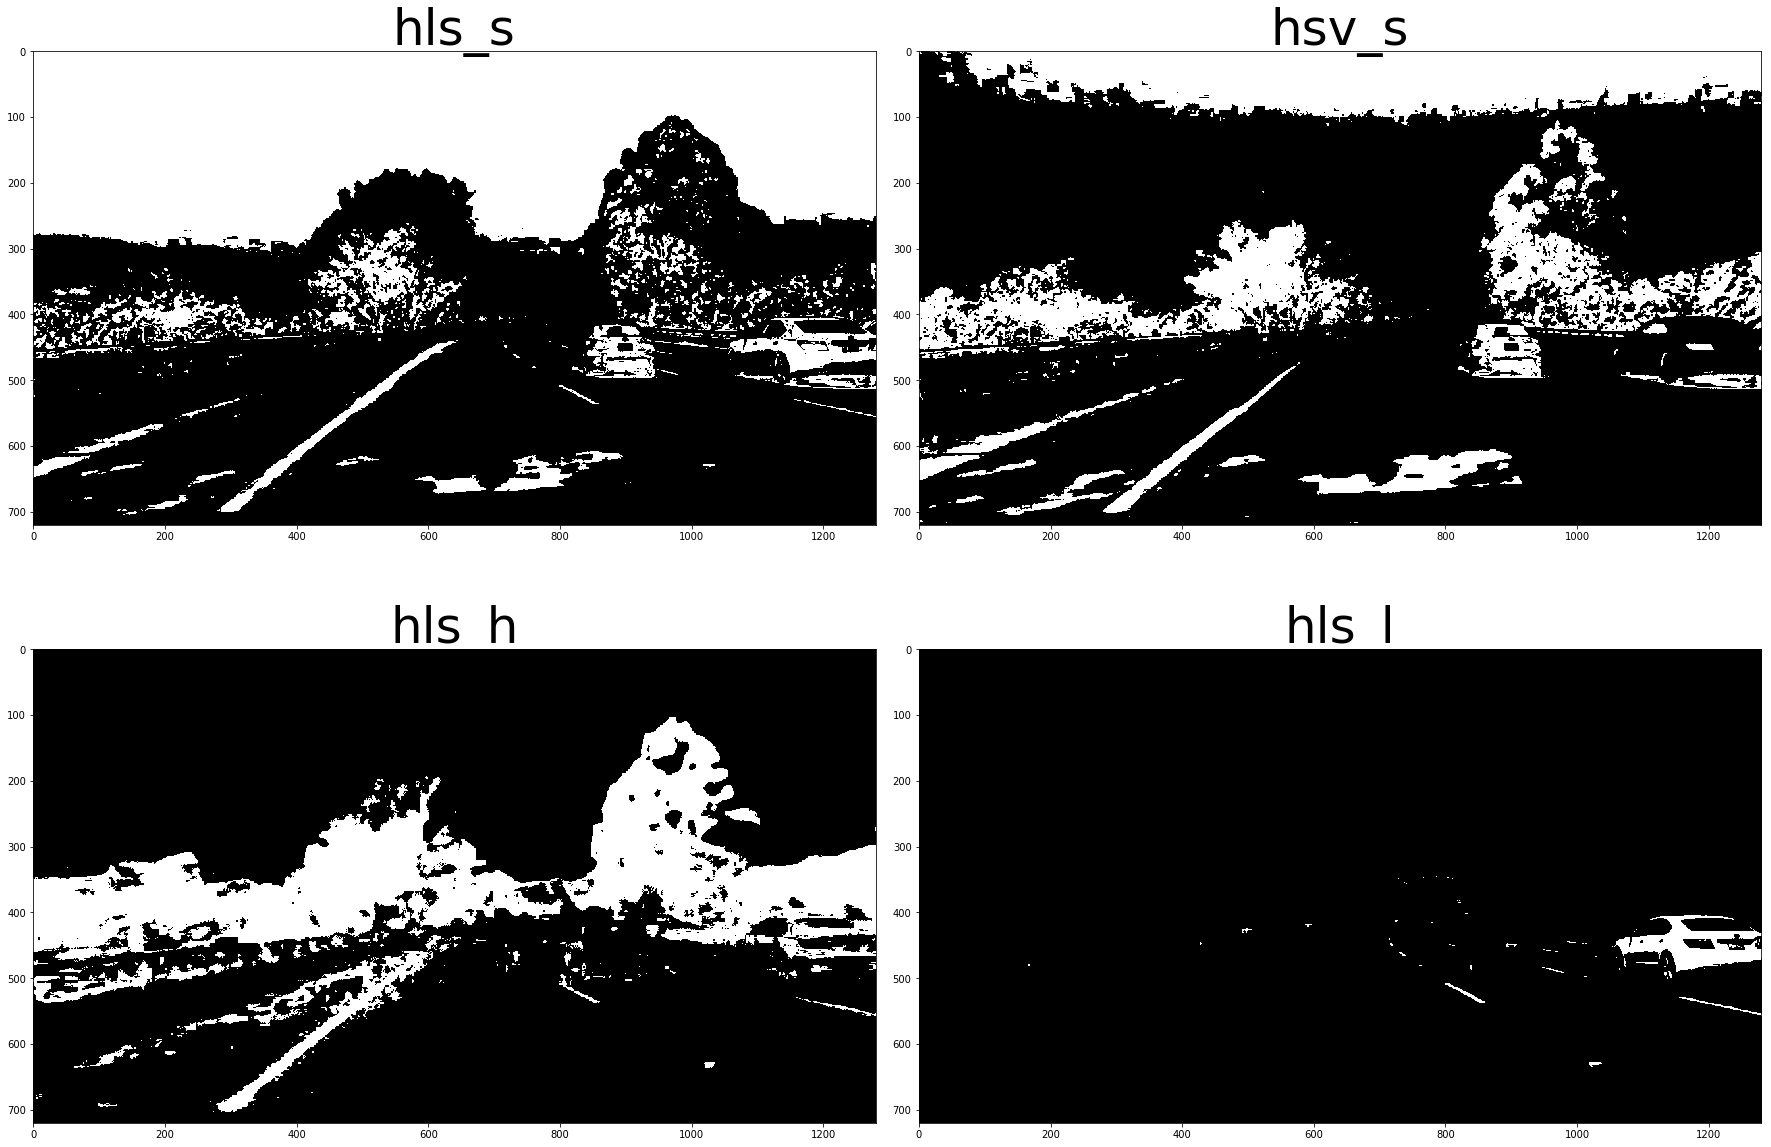

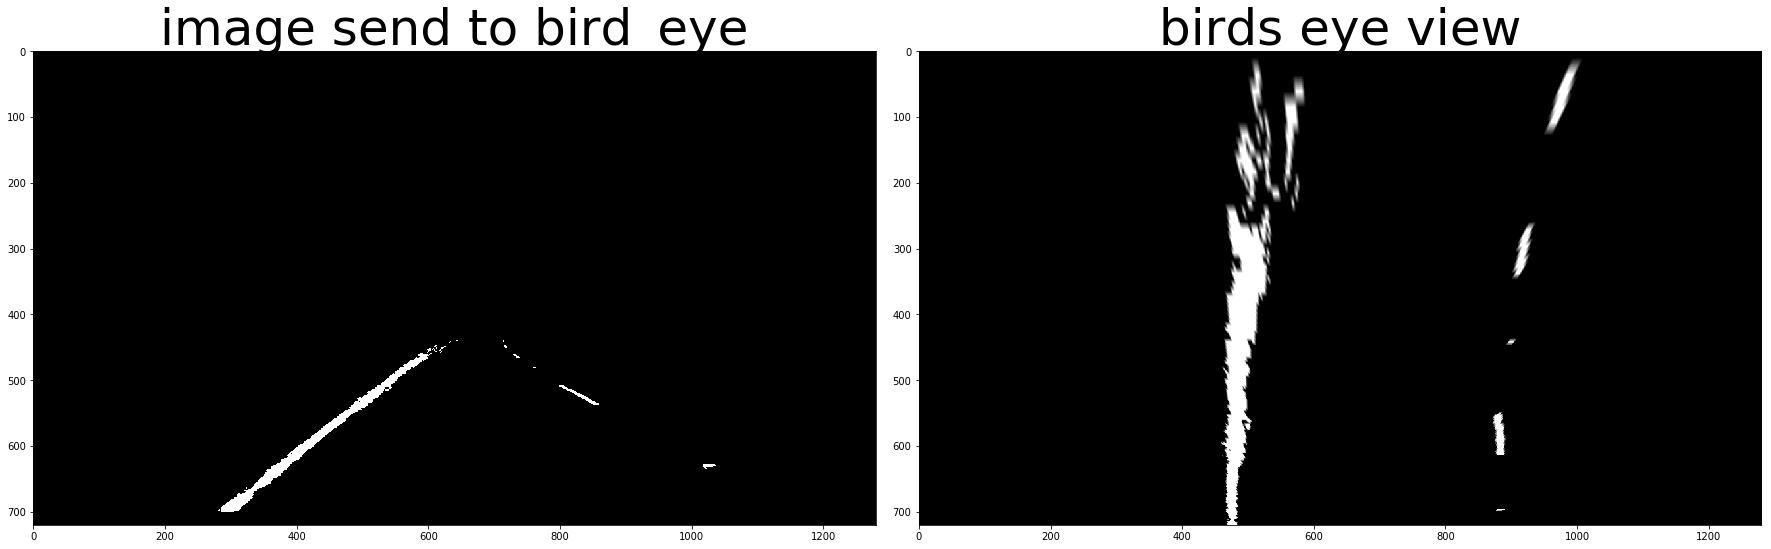

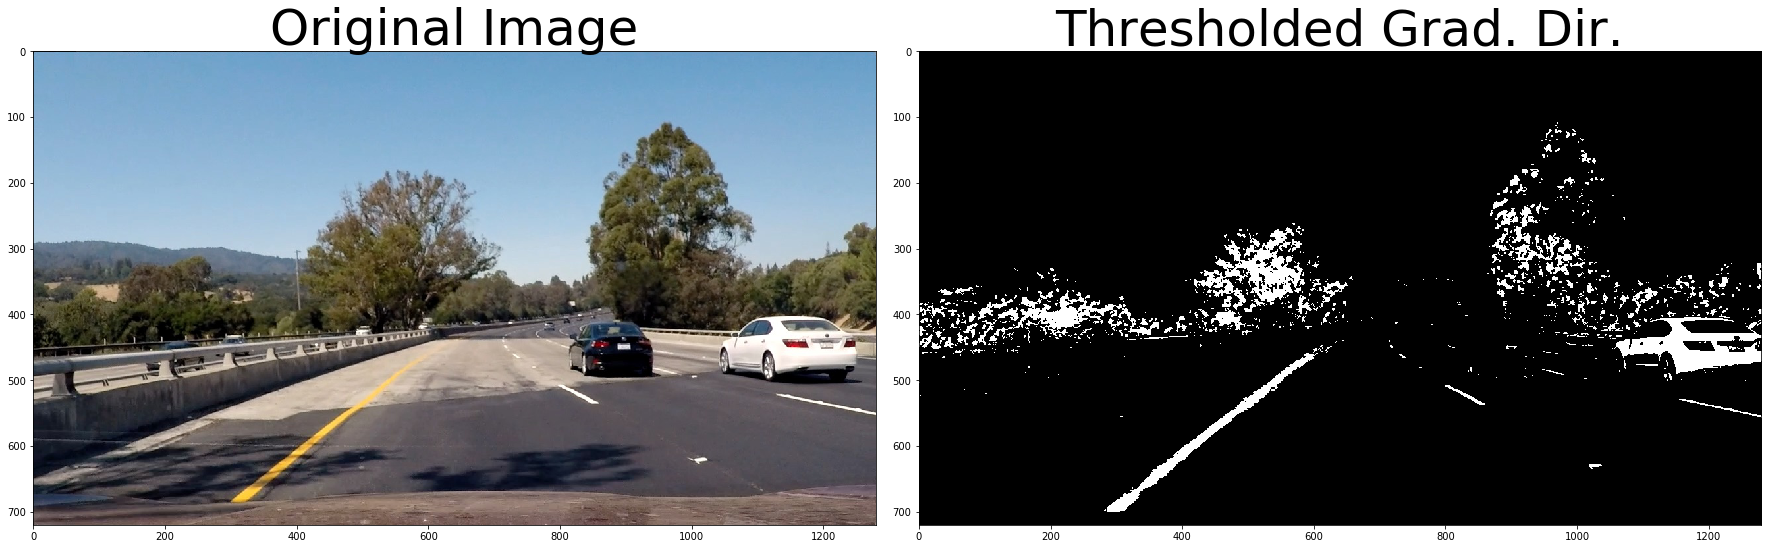

In [10]:
# image = cv2.imread("test_images/test1.jpg")
image = cv2.imread("test_images/test4.jpg")
img = cv2.undistort(image, mtx, dist, None, mtx)
binary_image = combine_color_grad(img, debug=True)
masked = region_of_interest(binary_image)
M, Minv = find_matrix()
# masked = gaussian_blur(masked, kernel_size=5)
warped = birds_eye(masked, M, debug=True)

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
# ax2.imshow(image)
ax2.imshow(binary_image, cmap='gray')
ax2.set_title('Thresholded Grad. Dir.', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Detect lane pixels and fit to find the lane boundary.

In [11]:
def draw_lane(img, left_fit, right_fit):
    window_img = np.zeros_like(img)
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    left_line_window = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    right_line_window = np.array([np.flipud(np.transpose(np.vstack([right_fitx, 
                                  ploty])))])
    lane_pts = np.hstack((left_line_window, right_line_window))
    cv2.fillPoly(window_img, np.int_([lane_pts]), (0,255, 0))
    out_img = cv2.addWeighted(img, 1, window_img, 0.3, 0)
    
    return out_img
    

def seperate_fit_first_time(binary_warped, debug=False):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = binary_warped.copy()
    out_img = np.uint8((out_img-np.min(out_img))/(np.max(out_img)-np.min(out_img))*255)
    out_img = np.dstack((out_img, out_img, out_img))
#     out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
#     out_img = np.uint8(out_img)
    if debug:
        fig, ax = plt.subplots(figsize=(12, 7))
        ax.imshow(out_img)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        if debug:
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
            (0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
            (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    
    # Extract left and right line pixel positions
    if np.sum(left_lane_inds) < 50:
        left_fit = np.array([np.nan,np.nan,np.nan])
    else:
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        left_fit = np.polyfit(lefty, leftx, 2)
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    
    if np.sum(right_lane_inds) < 50:
        right_fit = np.array([np.nan,np.nan,np.nan])
    else:
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 
        right_fit = np.polyfit(righty, rightx, 2)
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # draw lane in green color
    if debug:
        out_img = draw_lane(out_img, left_fit, right_fit)
    
    if debug:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        fig, ax = plt.subplots(figsize=(12, 7))
        ax.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        
    return left_fit, right_fit, out_img

def seperate_fit_with_reference(binary_warped, line_obj, debug=False):
    out_img = binary_warped.copy()
    out_img = np.uint8((out_img-np.min(out_img))/(np.max(out_img)-np.min(out_img))*255)
    out_img = np.dstack((out_img, out_img, out_img))
    
    if debug:
        left_fit, right_fit = line_obj
    else:
        left_fit, right_fit = line_obj.average_fit
        
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) &
                      (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) &
                       (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
      
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    # Extract left and right line pixel positions
    if np.sum(left_lane_inds) < 50:
        left_fit = np.array([np.nan,np.nan,np.nan])
    else:
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        left_fit = np.polyfit(lefty, leftx, 2)
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    
    if np.sum(right_lane_inds) < 50:
        right_fit = np.array([np.nan,np.nan,np.nan])
    else:
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 
        right_fit = np.polyfit(righty, rightx, 2)
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    if debug:
        out_img = draw_lane(out_img, left_fit, right_fit)
    
    if debug:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
        window_img = np.zeros_like(out_img)
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                      ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                      ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        out_img = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        
        fig, ax = plt.subplots(figsize=(12, 7))
        ax.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        
    return left_fit, right_fit, out_img

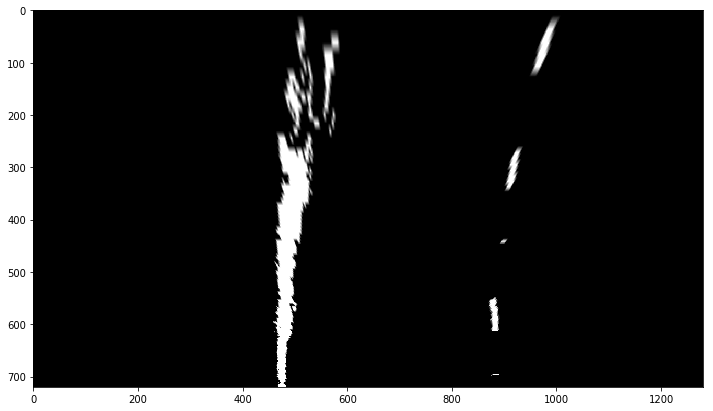

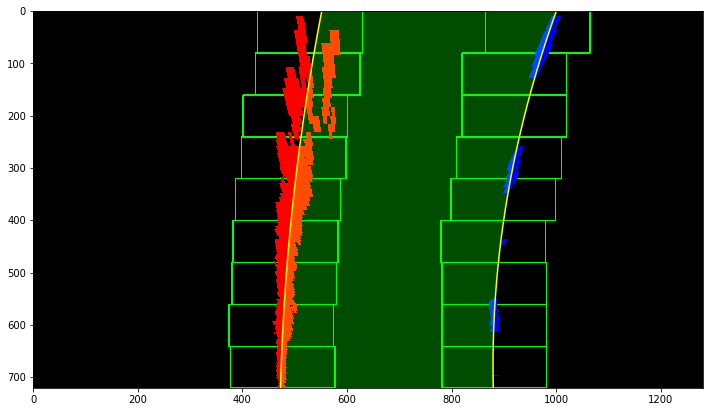

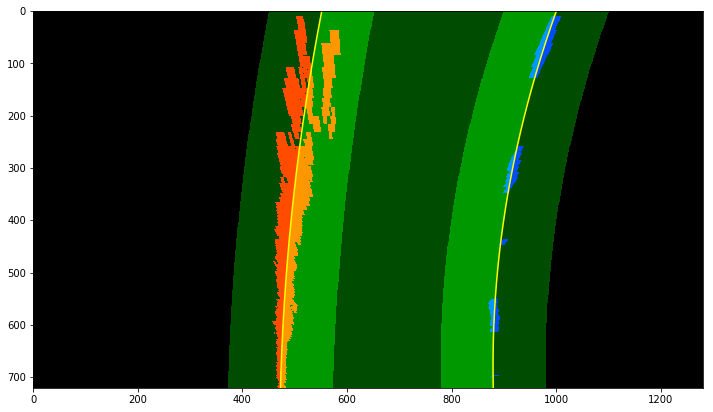

In [12]:
left_fit, right_fit, out_img = seperate_fit_first_time(warped, debug=True)
left_fit, right_fit, out_img = seperate_fit_with_reference(warped, [left_fit, right_fit], debug=True)

### Determine the curvature of the lane and vehicle position with respect to center.

In [13]:
# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
def radius(left_fit, right_fit):
    ploty = np.linspace(0, 719, num=720)
    y_eval = np.max(ploty)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
#     print(left_curverad, right_curverad)
    # Example values: 1926.74 1908.48

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/700 # meters per pixel in y dimension
    xm_per_pix = 3.7/400 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return left_curverad, right_curverad

left_curverad, right_curverad = radius(left_fit, right_fit)
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')
# Example values: 632.1 m    626.2 m

858.540826578 m 377.03541324 m


## Test on Videos

In [14]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [15]:
class Line():
    def __init__(self):
        self.buffer_size = 15
        self.need_complete_search = True
        # tolerance of left and right difference, in pixels, note the diff is normalized, 0 means good
        self.lr_diff_tolerance = 500
        # tolerance of current and average difference in pixels
        self.ca_diff_tolerance = self.lr_diff_tolerance
        # was the line detected in the last iteration?
        self.detected = [False, False]  
        # x values of the last n fits of the line
        self.recent_fit = np.full((self.buffer_size, 2, 3), np.nan)
        #polynomial coefficients averaged over the last n iterations
        self.average_fit = np.array([[np.nan, np.nan, np.nan],[np.nan, np.nan, np.nan]])
        self.average_fit_middle = np.array([np.nan, np.nan, np.nan])
        #polynomial coefficients for the most recent fit
        self.current_fit = np.array([False, False])
        #radius of curvature of the line in some units
        self.radius_of_curvature = np.full((self.buffer_size,3), np.nan)
        #distance in meters of vehicle center from the line
        self.line_base_pos = None  
        self.line_base_offset = None
        #difference in fit coefficients between last and new fits
        self.pair_diff = np.array([np.nan, np.nan])
        self.average_diff = np.array([np.nan, np.nan])
        self.previous_diff = np.full((1,2,2), np.nan)
        self.top_bot_intersect_current = np.array([[np.nan, np.nan],[np.nan, np.nan]])
        self.top_bot_intersect_average = np.array([[np.nan, np.nan],[np.nan, np.nan]])
        
    def add(self, left_fit, right_fit):
        self.current_fit = np.array([[left_fit, right_fit]])
        ploty = np.array([0, 719])
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        self.top_bot_intersect_current = np.array([left_fitx, right_fitx])
        
        if False not in np.isnan(self.average_fit): # if average_fit is NaN
            if self.check_pair_diff() == 'good':  # if left and right fits difference is 'ok'
                self.add_to_recent(mask=[[0,0,0],[0,0,0]])
            else:
                pass
        else:
            left, right = self.check_previous_diff() # compare with previous average
            self.add_to_recent(mask=np.array([left, right]))
        self.update()
                               
    def add_to_recent(self, mask):
        self.recent_fit = np.append(np.delete(self.recent_fit, 0, axis=0), self.current_fit+mask, axis=0)

    def update(self):
        self.detected = np.invert(np.isnan(np.nanmean(self.current_fit, axis=1)))
        self.average_fit = np.nanmean(self.recent_fit, axis=0)
        if True in np.isnan(self.average_fit):
            self.need_complete_search = True
        else:
            self.need_complete_search = False
        left_fit, right_fit = self.average_fit
        ploty = np.array([0, 719])
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        self.top_bot_intersect_average = np.array([left_fitx, right_fitx])
        self.line_base_pos = (self.top_bot_intersect_average[0,1] + self.top_bot_intersect_average[1,1]) / 2
        self.line_base_offset = (640 - self.line_base_pos) * 3.7/400
        self.average_fit_middle = np.nanmean(self.average_fit, axis=0)
        _, _, _ = self.radius()
        
    
    def check_pair_diff(self):
        left_fitx, right_fitx = self.top_bot_intersect_current
        self.pair_diff = right_fitx - left_fitx
        if left_fitx[0] < 0 or self.pair_diff[0] < 200 or right_fitx[0]>1280 or left_fitx[1]>600 or right_fitx[1]<680:
            return 'bad' # bad result
        else:
            return 'good'  # good result
            
    def check_previous_diff(self):
        """
        create a mask for bad data
        """
        diff_left, diff_right = self.top_bot_intersect_current - self.top_bot_intersect_average
        if True in (np.absolute(diff_left) > self.ca_diff_tolerance) or (self.check_pair_diff() == 'bad'):
            left = [np.nan, np.nan, np.nan]
        else:
            left = [0,0,0]
        if True in (np.absolute(diff_right) > self.ca_diff_tolerance) or (self.check_pair_diff() == 'bad'):
            right = [np.nan, np.nan, np.nan]
        else:
            right = [0,0,0]
        return left, right
        
    def radius(self):
        left_fit, right_fit = self.average_fit
        middle_fit = self.average_fit_middle
        ploty = np.linspace(0, 719, num=720)
        y_eval = np.max(ploty)
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        middle_fitx = middle_fit[0]*ploty**2 + middle_fit[1]*ploty + middle_fit[2]

        left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
        right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    #     print(left_curverad, right_curverad)
        # Example values: 1926.74 1908.48

        # Define conversions in x and y from pixels space to meters
        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meters per pixel in x dimension
        
        self.offset_in_meters = xm_per_pix * (self.line_base_pos-1280/2)

        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
        middle_fit_cr = np.polyfit(ploty*ym_per_pix, middle_fitx*xm_per_pix, 2)
        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        middle_curverad = ((1 + (2*middle_fit_cr[0]*y_eval*ym_per_pix + middle_fit_cr[1])**2)**1.5) / np.absolute(2*middle_fit_cr[0])
        temp = np.delete(self.radius_of_curvature,0,axis=0)
        self.radius_of_curvature = np.append(temp, np.array([[left_curverad, right_curverad, middle_curverad]]), axis=0)
        return left_curverad, right_curverad, middle_curverad
        
line_obj = Line()

#### Image process pipeline

In [16]:
M, Minv = find_matrix()

trouble_count = 0
save_trouble_pics = True
def pipeline(image):
    global trouble_count
    image = cv2.cvtColor(image,cv2.COLOR_RGB2BGR)
    img = image.copy()
    img = cv2.undistort(img, mtx, dist, None, mtx)
    binary_image = combine_color_grad(img, debug=False)
    masked = region_of_interest(binary_image)
    # masked = gaussian_blur(masked, kernel_size=5)
    warped = birds_eye(masked, M, debug=False)
    if line_obj.need_complete_search:
        left_fit, right_fit, out_img = seperate_fit_first_time(warped, debug=False)
    else:
        left_fit, right_fit, out_img = seperate_fit_with_reference(warped, line_obj, debug=False)
    if save_trouble_pics & (False in line_obj.detected):
        cv2.imwrite('./trouble/{}.jpg'.format(trouble_count), img)
        trouble_count += 1
    line_obj.add(left_fit, right_fit)
    
    out_img = draw_lane(out_img, line_obj.average_fit[0], line_obj.average_fit[1])
    
    # unwarp
    unwarp =  birds_eye(out_img, Minv, debug=False)
    output = weighted_img(unwarp, img)
    output = cv2.cvtColor(output,cv2.COLOR_BGR2RGB)
    
    center_radius = np.nanmean(line_obj.radius_of_curvature[:,2])
    radius_text = "Lane Radius = {0:.2f} m".format(center_radius)
    off_center_text = "Off Center by: {0:.2f} m".format(line_obj.line_base_offset)
    cv2.putText(output,radius_text,(50,100), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(output,off_center_text,(50,150), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2,cv2.LINE_AA)
    
    
    return output

## Test on video

In [17]:
project_output = './output_videos/project_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
# clip1 = VideoFileClip("project_video.mp4").subclip(0,1)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video ./output_videos/project_video_output.mp4
[MoviePy] Writing video ./output_videos/project_video_output.mp4


100%|█████████▉| 1260/1261 [06:24<00:00,  2.48it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_videos/project_video_output.mp4 

CPU times: user 6min 28s, sys: 1min 19s, total: 7min 48s
Wall time: 6min 26s


In [18]:
HTML("""
<video width="960" height="540" controls>
 <source src={0}>
</video>
""".format("./output_videos/project_video_output.mp4"))